In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import isnan

In [2]:
def Load_Data(path_dir):
    list_text = os.listdir(path=path_dir)
    text_array = ''
    for text in list_text:
        with open(path_dir + text, 'r') as f:
            text_array+= f.readline() + '\n'
    text_array = text_array.replace('\ufeff', '')
    list_of_files = text_array.split('\n')
    for i in range(len(list_of_files)):
        list_of_files[i] = list_of_files[i].split('\t')
    text_tmp = []
    for i in range(len(list_of_files)):
        if list_of_files[i] != ['']:
            text_tmp.append(list_of_files[i])
    return text_tmp

In [3]:
def ParseData(data):
    list_of_sites, body_array, values = [],[],[];
    for i in range(len(data)):
        body_array.append([])
        for j in range(len(data[i])):
            if j == 0:
                list_of_sites.append(data[i][j])
            elif j == len(data[i])-1:
                values.append(int(data[i][j]))
            else:
                if j != 4:
                    if data[i][j] == 'null':
                        body_array[i].append(0)
                    elif data[i][j] == 'true':
                        body_array[i].append(1)
                    elif data[i][j] == 'false':
                        if j == 2:
                            body_array[i].append(0)
                        else:
                            body_array[i].append(-1)
                    else:
        #                 print(text_array[i][j])
                        body_array[i].append(float(data[i][j]))
    return list_of_sites, np.array(body_array), np.array(values)

In [5]:
_, data_train, val_train = ParseData(Load_Data('New_train/'))
_, data_test, val_test = ParseData(Load_Data('New_test/'))
_, data_val,val_val = ParseData(Load_Data('New_val/'))

In [6]:
def get_color_array(array, f):
    return ['red' if f(array[i]) > 0.5 else 'blue' for i in range(len(array))]

In [7]:
val_train_color = get_color_array(val_train, lambda x: x)
val_test_color = get_color_array(val_test, lambda x: x)

In [8]:
from sklearn.manifold import TSNE

In [9]:
model_to2D = TSNE(learning_rate=100)
transform = model_to2D.fit_transform(data_train)

In [10]:
x = transform[:,0]
y = transform[:,1]

In [11]:
import torch
import numpy as np

from torch.optim import Adam

from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import nn

In [12]:
X_train = torch.tensor(data_train, dtype=torch.float)
y_train = torch.tensor(val_train, dtype=torch.float).view(-1,1)

In [13]:
data = TensorDataset(X_train, y_train)

In [14]:
class PhishingRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(data_train.shape[1], 50)
        self.linear2 = nn.Linear(50, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear2(torch.sigmoid(self.linear1(x))))

In [15]:
X_val = torch.tensor(data_val, dtype=torch.float)

In [16]:
def train_model(model):
    optimizer = Adam(model.parameters(), lr=1e-3)

    loss = nn.BCELoss()
    train_loader = DataLoader(dataset=data, batch_size=20)
    epoch = 0
    while True:
        for X_batch, y_batch in train_loader:   
            y_pred = model(X_batch)    
            bce = loss(y_pred, y_batch)

            bce.backward()        

            optimizer.step()
            optimizer.zero_grad()       
           
        epoch += 1
        if epoch % 1000 == 0:
            acc = round(sum([int(val_val[i] == int(model(X_val[i])>0.5)) for i in range(X_val.shape[0])])/val_val.shape[0], 2)
            print(f'Epoch = {epoch}, loss = {bce}, acc = {acc}')
        if bce < 0.0000001:
            break

In [17]:
model = PhishingRegressor()

In [18]:
train_model(model)

Epoch = 1000, loss = 0.00272630644030869, acc = 1.0
Epoch = 2000, loss = 3.9210044633364305e-05, acc = 1.0
Epoch = 3000, loss = 4.1723305344021355e-07, acc = 1.0


In [20]:
res_train_color = get_color_array(X_train, model)

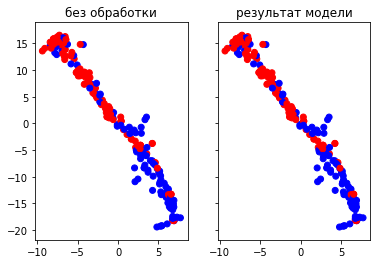

In [21]:
f_train, ax1 = plt.subplots(1,2, sharey=True)
ax1[0].scatter(x, y, c=val_train_color)
ax1[0].set_title('без обработки')
ax1[1].scatter(x, y, c=res_train_color)
ax1[1].set_title('результат модели')
plt.show()

In [22]:
transform_test = model_to2D.fit_transform(data_test)
x_2 = transform_test[:, 0]
y_2 = transform_test[:, 1]

In [23]:
X_test = torch.tensor(data_test, dtype=torch.float)

In [24]:
res_color_test = get_color_array(X_test, model)

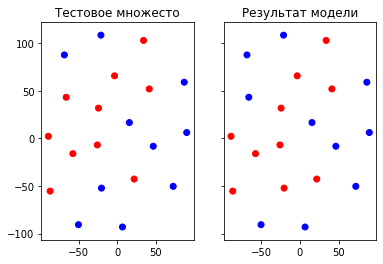

In [25]:
f_test, ax2 = plt.subplots(1,2, sharey=True)
ax2[0].scatter(x_2, y_2, c=val_test_color)
ax2[0].set_title('Тестовое множесто')
ax2[1].scatter(x_2, y_2, c=res_color_test)
ax2[1].set_title('Результат модели')
plt.show()

In [26]:
acc = sum([int(val_test[i] == int(model(X_test[i])>0.5)) for i in range(X_test.shape[0])])/X_test.shape[0]

In [27]:
acc

0.9

In [28]:
def F_b (b=1):
    return (1+b**2)*(precision*recall)/(b**2*precision+recall)

In [29]:
TP = 0
FP = 0
FN = 0
for i in range(len(val_test)):
    if val_test[i] == int(model(X_test[i])>0.5):
        if int(model(X_test[i])>0.5) == 1:
            TP += 1
    else:
        if int(model(X_test[i])>0.5) == 0:
            FN += 1
        else:
            FP += 1
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_b()

0.9